In [1]:
import torch, pickle, argparse, mlflow, os
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet
from data_loader import load_train_data, load_test_data
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfProjectedGradientDescentAttack
from foolbox.attacks.base import Repeated
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack_cpu, batched_accuracy
from mlflow.tracking.artifact_utils import get_artifact_uri

In [2]:
total = 6
bs = 6
run_name = 1671715247

In [3]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = ConvNet(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])

if test_rot:
    TEST_PATH = "s2_mnist_cs1.gz"
    test_data = load_test_data(TEST_PATH)
else:
    TEST_PATH = "s2_mnist_test_sphere_center.gz"
    test_data = load_train_data(TEST_PATH)

images = test_data[:total][0]
labels = test_data[:total][1]



fmodel = PyTorchModel(model, bounds=(0, 255))

In [4]:
output = model(images.cuda())
clean_pred = torch.max(output, 1)[1]

In [6]:
n_steps = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epsilons = [0.1, 0.5, 1, 5, 10, 20, 30, 50, 80, 100]
rel_stepsizes = [0.01, 0.01/0.3, 0.05]
random_starts = [False, True]
success = []

for random_start in random_starts:
    outer_dummy = []
    for rel_stepsize in rel_stepsizes:
        dummy = []
        for steps in n_steps:
            if random_start:
                attack = Repeated(LinfProjectedGradientDescentAttack(rel_stepsize=rel_stepsize, steps=steps, random_start=random_start), 3)
            else:
                attack = LinfProjectedGradientDescentAttack(rel_stepsize=rel_stepsize, steps=steps, random_start=random_start)
            raw_advs_cpu, clipped_advs_cpu, success_cpu = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons, bs)
            dummy.append(success_cpu.numpy())
        outer_dummy.append(dummy)
    success.append(outer_dummy)
    
success = torch.as_tensor(np.array(success))

success_rate = ep.astensor(success).float32().mean(axis=-1).raw

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

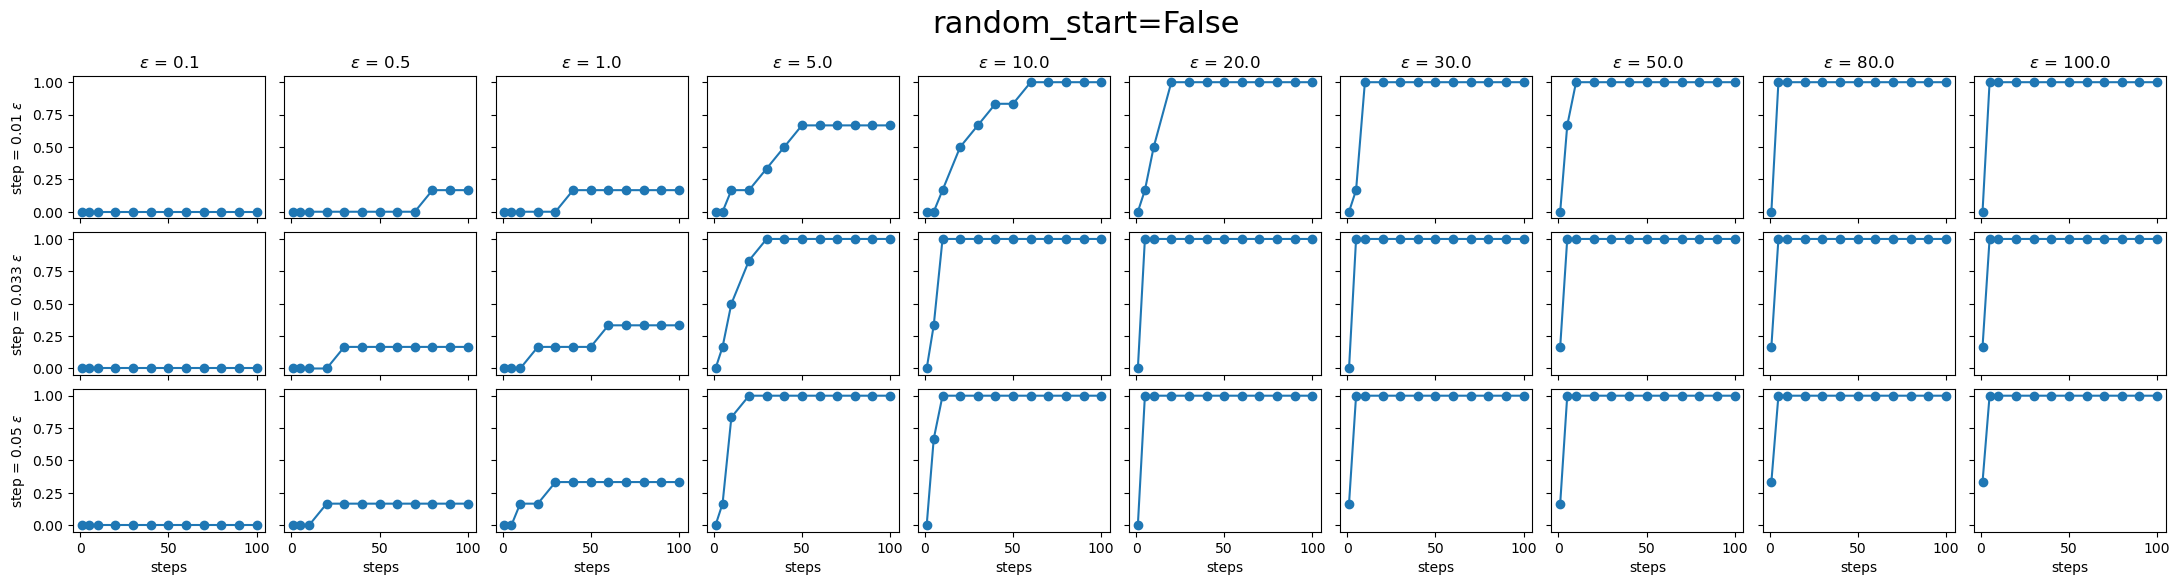

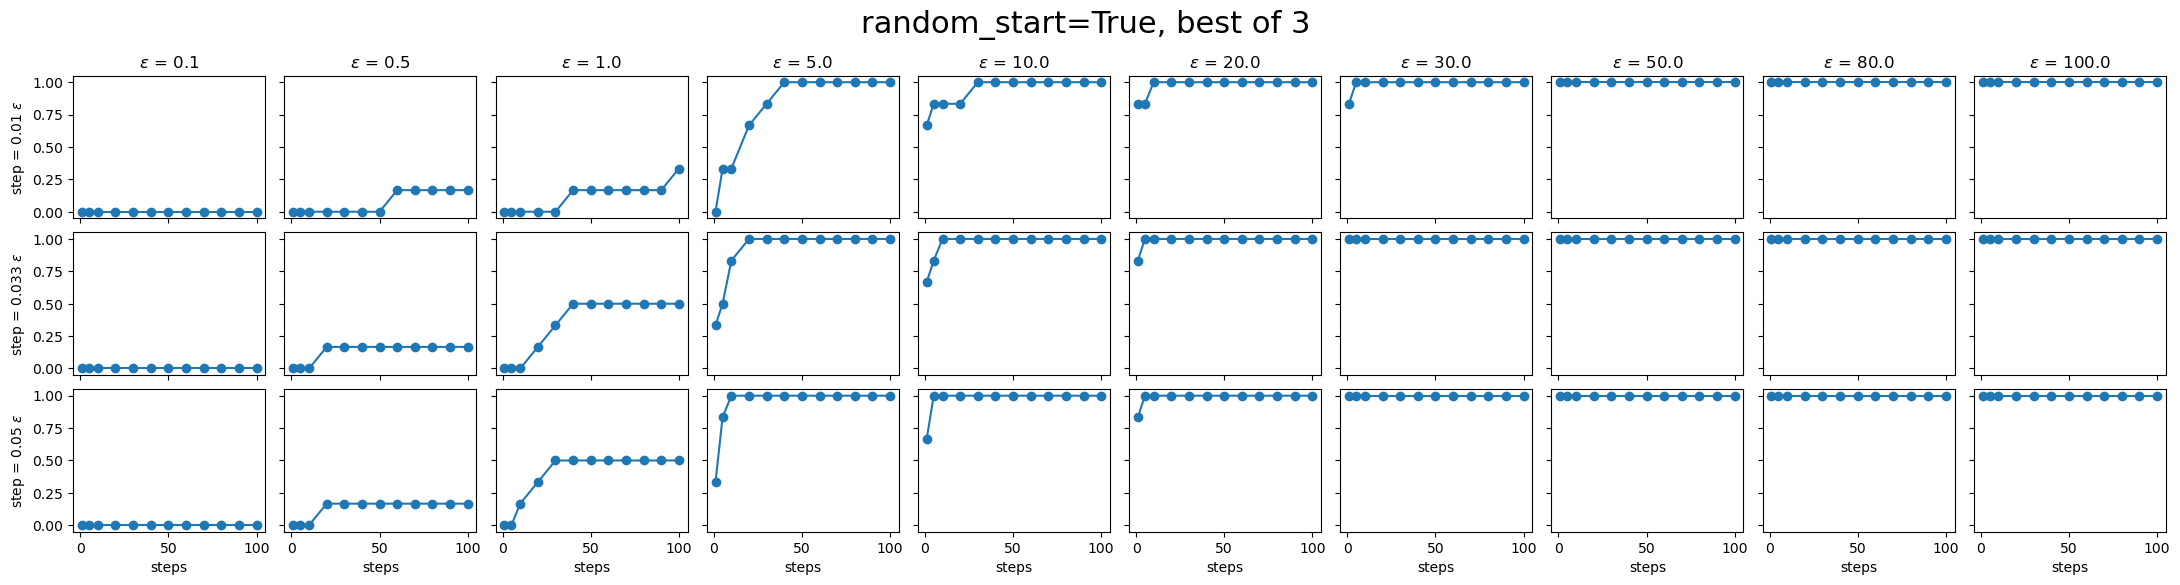

In [7]:
title_helper = ['', ', best of 3']
for k in range(2):
    fontsize = 50

    fig, axs = plt.subplots(nrows=3, ncols=10, figsize = (27, 6), sharey=True, sharex=True, gridspec_kw = {'wspace':0.1, 'hspace':0.1})
    fig.suptitle(f'random_start={str(random_starts[k])+title_helper[k]}', fontsize=22)
    plt.subplots_adjust(top=0.87)

    for j in range(success_rate.size(1)):
        for i in range(success_rate.size(3)):
            axs[j,i].plot(n_steps, success_rate[k,j,:,i], 'o-')
            axs[0,i].set_title(r'$\epsilon$ = %.1f' %(epsilons[i]))

        axs[j,0].set_ylabel(f'step = {rel_stepsizes[j]:{1}.{2}} $\epsilon$')
        
    for i in range(success_rate.size(3)):
        axs[2,i].set_xlabel('steps')

    plt.show()

choose: <br>
 - random_start = True
 - relative step size = 0.05
 - steps = 50
 - $\epsilon_{\mathrm{max}} \approx 10$